#MODULE 1 Code Used for modifiying dataset:

In [ ]:
import requests
import csv
import time
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from textblob import TextBlob
import nltk
from nltk.stem import PorterStemmer, WordNetLemmatizer

# Download necessary NLTK data
nltk.download('wordnet')
nltk.download('omw-1.4')

# Initialize stemmer and lemmatizer for column name cleaning
ps = PorterStemmer()
lemmatizer = WordNetLemmatizer()

def clean_column_name(col_name):
    """
    Clean a column name by splitting it into tokens (using spaces and underscores),
    applying stemming and lemmatization on each token, and reassembling the tokens.
    """
    tokens = re.split(r'[\s_]+', col_name)
    cleaned_tokens = [lemmatizer.lemmatize(ps.stem(token.lower())) for token in tokens if token]
    return '_'.join(cleaned_tokens)

# ---------------------
# Data Collection Block
# ---------------------

# API Key for The Guardian
guardian_key = "ee79cd97-ef16-4aea-ab5c-0dbcc87018d6"

# API Endpoint
guardian_endpoint = "https://content.guardianapis.com/search"

# Topics to fetch data
topics = [
    "road accident", "train accident", "airplane crash", "natural disaster",
    "fire accident", "industrial accident", "bike accident", "car collision",
    "truck accident", "boat accident", "bus accident", "subway accident",
    "construction site accident", "factory explosion", "mining accident",
    "power plant failure", "chemical spill", "oil rig disaster", "earthquake damage",
    "hurricane impact", "tsunami destruction", "landslide accident", "volcanic eruption",
    "flooding disaster", "severe storm damage", "avalanche accident", "residential fire",
    "gas leak explosion", "forest wildfire", "electrical fire", "industrial plant fire",
    "warehouse fire", "mass casualty incident", "hospital emergency evacuation",
    "building collapse", "bridge collapse", "dam failure", "toxic gas exposure",
    "radiation leak accident"
]

# Output file for raw data
filename = "guardian_accidents_data.csv"

# Open CSV file and write headers
with open(filename, mode="w", newline="", encoding="utf-8") as myfile:
    csv_writer = csv.writer(myfile)
    csv_writer.writerow(["Label", "Source", "Title", "Description", "Published At", "URL", "Content"])

    for topic in topics:
        print(f"Fetching data for: {topic}")
        for page in range(1, 6):  # Fetch up to 5 pages per topic
            params = {
                'api-key': guardian_key,
                'q': topic,
                'page-size': 100,
                'page': page,
                'order-by': 'relevance',
                'show-fields': 'headline,bodyText,publication'
            }
            try:
                response = requests.get(guardian_endpoint, params=params)
                if response.status_code == 200:
                    jsontxt = response.json()
                    if "response" not in jsontxt or "results" not in jsontxt["response"] or not jsontxt["response"]["results"]:
                        print(f"No more data for {topic} on page {page} (The Guardian).")
                        break

                    for article in jsontxt["response"]["results"]:
                        label = topic
                        source = article.get("sectionName", "The Guardian")
                        title = article.get("webTitle", "N/A")
                        description = article.get("fields", {}).get("bodyText", "N/A")[:250]  # First 250 chars
                        published_at = article.get("webPublicationDate", "N/A")
                        url = article.get("webUrl", "N/A")
                        content = article.get("fields", {}).get("bodyText", "N/A")

                        # Filter articles based on keywords in title
                        if any(keyword in title.lower() for keyword in ["accident", "crash", "collision", "fire", "injured", "died"]):
                            csv_writer.writerow([label, source, title, description, published_at, url, content])
                    print(f"The Guardian API: Page {page} collected for {topic}")
                else:
                    print(f"The Guardian API failed for {topic}, Status Code: {response.status_code}")
                    break
                time.sleep(2)  # Sleep to avoid rate limits
            except Exception as e:
                print(f"Error fetching data for {topic} from The Guardian API on page {page}: {e}")
                break

print(f"News articles successfully written to {filename}.")

# ---------------------
# Data Cleaning & Preprocessing Block
# ---------------------

# Load dataset
file_path = "guardian_accidents_data.csv"
df_raw = pd.read_csv(file_path)

# Display dataset info before preprocessing
print("Dataset Overview Before Preprocessing")
print("Number of Rows:", df_raw.shape[0])
print("Number of Columns:", df_raw.shape[1])
print("Column Names:", df_raw.columns.tolist())
print("Missing Values:\n", df_raw.isnull().sum())
print("Duplicate Entries:", df_raw.duplicated().sum())

# Convert 'Published At' to datetime
df_raw['Published At'] = pd.to_datetime(df_raw['Published At'], errors='coerce')

# Dropping duplicates
df_cleaned = df_raw.drop_duplicates()

# Removing columns that are not useful (e.g., URL)
columns_to_remove = ['URL']  # Adjust this list as needed
df_cleaned.drop(columns=columns_to_remove, inplace=True, errors='ignore')

# Standardizing text fields (lowercasing, removing special characters)
def clean_text(text):
    if isinstance(text, str):
        text = text.lower()
        text = re.sub(r'\W+', ' ', text)
        return text.strip()
    return text

df_cleaned['Title'] = df_cleaned['Title'].apply(clean_text)
df_cleaned['Description'] = df_cleaned['Description'].apply(clean_text)
df_cleaned['Content'] = df_cleaned['Content'].apply(clean_text)

# Checking for outliers in numeric columns (if any exist)
num_cols = df_cleaned.select_dtypes(include=[np.number]).columns
if not num_cols.empty:
    df_cleaned[num_cols] = df_cleaned[num_cols].apply(lambda x: x.clip(lower=x.quantile(0.01), upper=x.quantile(0.99)))
    print("\nData after handling outliers:")
    print(df_cleaned.describe())

# Sentiment Analysis on the Description field
df_cleaned['Sentiment'] = df_cleaned['Description'].apply(lambda x: TextBlob(x).sentiment.polarity)

# TF-IDF Vectorization on the Content field
vectorizer = TfidfVectorizer(max_features=500, stop_words='english')
tfidf_matrix = vectorizer.fit_transform(df_cleaned['Content'])
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())

# Combine with the cleaned dataset
df_final = pd.concat([df_cleaned.reset_index(drop=True), tfidf_df], axis=1)

# Convert 'Published At' to datetime and set as index for time-based analysis
df_final['Published At'] = pd.to_datetime(df_final['Published At'])
df_final.set_index('Published At', inplace=True)

# Create additional time-based features
df_final['Month'] = df_final.index.month
df_final['Day_of_Week'] = df_final.index.dayofweek  # 0 = Monday, 6 = Sunday
df_final['Hour'] = df_final.index.hour

# ---------------------
# Update Column Names using Stemming and Lemmatization
# ---------------------

# Create a dictionary to map original column names to cleaned names
new_column_names = {col: clean_column_name(col) for col in df_final.columns}
df_final.rename(columns=new_column_names, inplace=True)

print("\nUpdated Column Names:")
print(df_final.columns.tolist())

# Identify column names that are purely numeric
numeric_like_cols = [col for col in df_final.columns if re.fullmatch(r'\d+', col)]
print("\nColumns with names that are numbers:", numeric_like_cols)

# Drop columns with names that are purely numeric to reduce dimensionality
if numeric_like_cols:
    df_final.drop(columns=numeric_like_cols, inplace=True)
    print("\nDropped numeric-only columns:", numeric_like_cols)

# ---------------------
# Save the Final Cleaned Dataset
# ---------------------

cleaned_file_path = "accidents_cleaned.csv"
df_final.to_csv(cleaned_file_path, index=False)

print("\nFinal cleaned dataset saved as:", cleaned_file_path)
print(df_final.head())


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


Fetching data for: road accident
The Guardian API: Page 1 collected for road accident
The Guardian API: Page 2 collected for road accident
The Guardian API: Page 3 collected for road accident
The Guardian API: Page 4 collected for road accident
The Guardian API: Page 5 collected for road accident
Fetching data for: train accident
The Guardian API: Page 1 collected for train accident
The Guardian API: Page 2 collected for train accident
The Guardian API: Page 3 collected for train accident
The Guardian API: Page 4 collected for train accident
The Guardian API: Page 5 collected for train accident
Fetching data for: airplane crash
The Guardian API: Page 1 collected for airplane crash
The Guardian API: Page 2 collected for airplane crash
The Guardian API: Page 3 collected for airplane crash
The Guardian API: Page 4 collected for airplane crash
The Guardian API: Page 5 collected for airplane crash
Fetching data for: natural disaster
The Guardian API: Page 1 collected for natural disaster
Th

#Principal Component Analysis (PCA)

In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd


# 1. Extract only numeric data (removing qualitative labels)
df_numeric = df_final.select_dtypes(include=[np.number])
print("Numeric columns used for PCA:")
print(df_numeric.columns.tolist())
print("\nData Sample before PCA:")
print(df_numeric.head())

# 2. Normalize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_numeric)
print(scaled_data)





Numeric columns used for PCA:
['sentiment', 'abl', 'accid', 'accord', 'acr', 'act', 'act', 'action', 'ad', 'ad', 'administr', 'affect', 'afternoon', 'agenc', 'agenc', 'ago', 'aid', 'air', 'aircraft', 'airlin', 'airport', 'altadena', 'american', 'angel', 'announc', 'area', 'area', 'armi', 'ask', 'associ', 'attack', 'australia', 'australian', 'author', 'aviat', 'away', 'bank', 'base', 'began', 'believ', 'best', 'better', 'biden', 'big', 'bird', 'bit', 'black', 'blaze', 'board', 'bodi', 'bodi', 'boe', 'brought', 'build', 'burn', 'burn', 'burn', 'busi', 'california', 'call', 'came', 'car', 'care', 'case', 'caus', 'caus', 'central', 'chang', 'chief', 'child', 'child', 'citi', 'clear', 'climat', 'close', 'close', 'collis', 'come', 'come', 'come', 'commun', 'commun', 'compani', 'compani', 'condit', 'confer', 'confirm', 'contain', 'continu', 'continu', 'control', 'cost', 'countri', 'counti', 'court', 'crash', 'crash', 'crew', 'crisi', 'cut', 'damag', 'danger', 'data', 'day', 'day', 'dead', 'de


PCA with 2 Components:
Explained Variance Ratio: [0.03132668 0.02836806]
Total Variance Retained in 2D: 5.97%

PCA 2D DataFrame (first 5 rows):
        PC1       PC2
0  0.549089  3.860436
1  3.930289 -0.819579
2 -1.034302  2.825415
3  1.500880  1.999385
4 -1.691008  1.178733


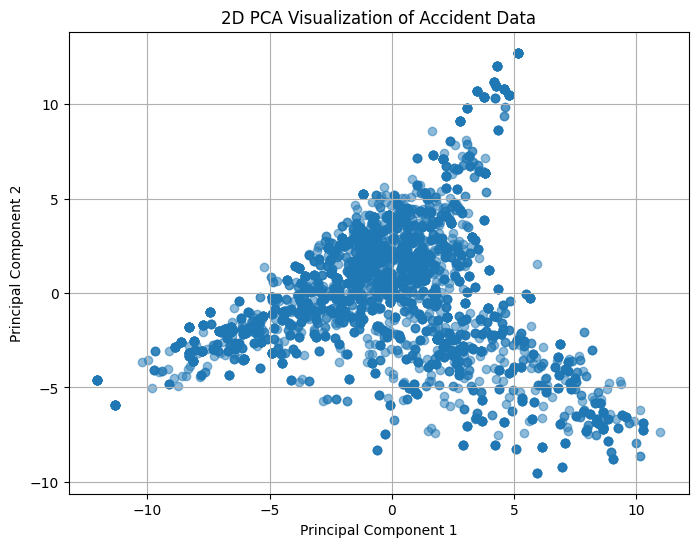

In [ ]:
# 3. Apply PCA with n_components = 2
pca2 = PCA(n_components=2)
pca2_data = pca2.fit_transform(scaled_data)
explained_variance_2d = pca2.explained_variance_ratio_
total_variance_2d = explained_variance_2d.sum() * 100
print("\nPCA with 2 Components:")
print("Explained Variance Ratio:", explained_variance_2d)
print("Total Variance Retained in 2D: {:.2f}%".format(total_variance_2d))

# Create DataFrame for 2D PCA result and print it
df_pca2 = pd.DataFrame(pca2_data, columns=["PC1", "PC2"])
print("\nPCA 2D DataFrame (first 5 rows):")
print(df_pca2.head())

# Visualize the 2D PCA result
plt.figure(figsize=(8,6))
plt.scatter(pca2_data[:, 0], pca2_data[:, 1], alpha=0.5)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('2D PCA Visualization of Accident Data')
plt.grid(True)
plt.show()




PCA with 3 Components:
Explained Variance Ratio: [0.03132668 0.02836806 0.0178175 ]
Total Variance Retained in 3D: 7.75%

PCA 3D DataFrame (first 5 rows):
        PC1       PC2       PC3
0  0.549729  3.859760  0.725119
1  3.930734 -0.820179  1.945082
2 -1.035059  2.826261  5.942587
3  1.501736  1.998208  3.914086
4 -1.690195  1.178383  0.060880


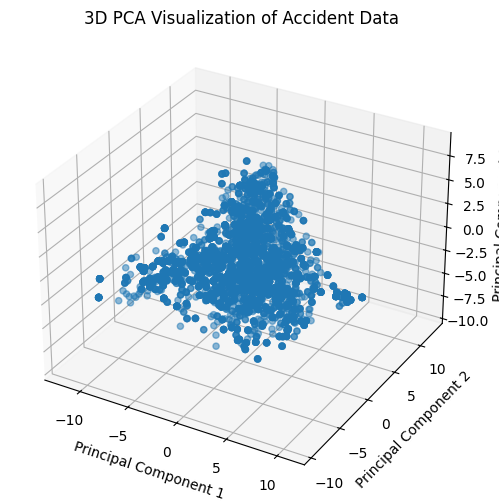

In [ ]:
# 4. Apply PCA with n_components = 3
pca3 = PCA(n_components=3)
pca3_data = pca3.fit_transform(scaled_data)
explained_variance_3d = pca3.explained_variance_ratio_
total_variance_3d = explained_variance_3d.sum() * 100
print("\nPCA with 3 Components:")
print("Explained Variance Ratio:", explained_variance_3d)
print("Total Variance Retained in 3D: {:.2f}%".format(total_variance_3d))

# Create DataFrame for 3D PCA result and print it
df_pca3 = pd.DataFrame(pca3_data, columns=["PC1", "PC2", "PC3"])
print("\nPCA 3D DataFrame (first 5 rows):")
print(df_pca3.head())

# Visualize the 3D PCA result
from mpl_toolkits.mplot3d import Axes3D  # For 3D plotting
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pca3_data[:, 0], pca3_data[:, 1], pca3_data[:, 2], alpha=0.5)
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
ax.set_title('3D PCA Visualization of Accident Data')
plt.show()


In [ ]:
# 5. Determine the number of dimensions needed to retain at least 95% variance
pca_full = PCA().fit(scaled_data)
cumulative_variance = np.cumsum(pca_full.explained_variance_ratio_)
n_components_95 = np.argmax(cumulative_variance >= 0.95) + 1  # +1 because index starts at 0
print("\nCumulative Explained Variance for all Components:")
for i, cum_var in enumerate(cumulative_variance, start=1):
    print("Component {}: {:.2f}%".format(i, cum_var * 100))
print("\nNumber of components needed to retain at least 95% of the variance:", n_components_95)






Cumulative Explained Variance for all Components:
Component 1: 3.13%
Component 2: 5.97%
Component 3: 7.75%
Component 4: 9.50%
Component 5: 10.88%
Component 6: 12.04%
Component 7: 13.12%
Component 8: 14.11%
Component 9: 15.02%
Component 10: 15.91%
Component 11: 16.75%
Component 12: 17.56%
Component 13: 18.35%
Component 14: 19.13%
Component 15: 19.86%
Component 16: 20.57%
Component 17: 21.27%
Component 18: 21.97%
Component 19: 22.65%
Component 20: 23.33%
Component 21: 24.00%
Component 22: 24.64%
Component 23: 25.28%
Component 24: 25.91%
Component 25: 26.54%
Component 26: 27.14%
Component 27: 27.74%
Component 28: 28.33%
Component 29: 28.92%
Component 30: 29.50%
Component 31: 30.06%
Component 32: 30.63%
Component 33: 31.18%
Component 34: 31.73%
Component 35: 32.27%
Component 36: 32.81%
Component 37: 33.34%
Component 38: 33.85%
Component 39: 34.37%
Component 40: 34.87%
Component 41: 35.38%
Component 42: 35.88%
Component 43: 36.37%
Component 44: 36.86%
Component 45: 37.35%
Component 46: 37.

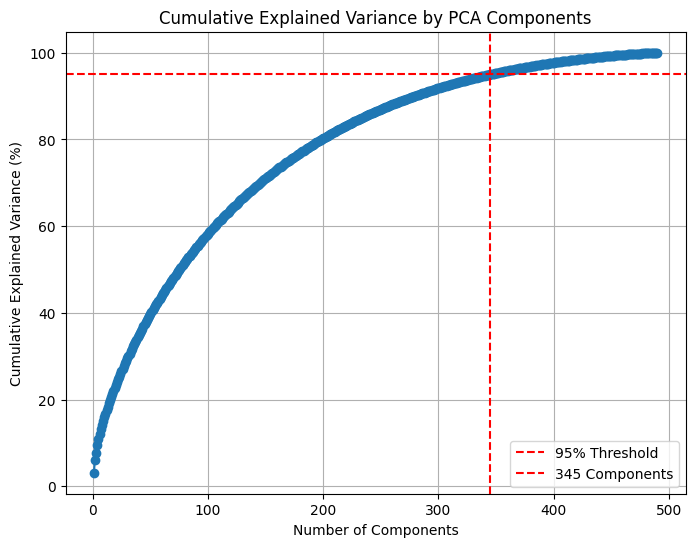

In [ ]:
# Visualize the cumulative explained variance (Scree Plot)
plt.figure(figsize=(8,6))
plt.plot(np.arange(1, len(cumulative_variance) + 1), cumulative_variance * 100, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance (%)')
plt.title('Cumulative Explained Variance by PCA Components')
plt.axhline(y=95, color='r', linestyle='--', label='95% Threshold')
plt.axvline(x=n_components_95, color='r', linestyle='--', label=f'{n_components_95} Components')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# 6. Output the top three eigenvalues (variance explained by the top three principal components)
top_three_eigenvalues = pca_full.explained_variance_[:3]
print("\nTop three eigenvalues of the data:")
print(top_three_eigenvalues)


Top three eigenvalues of the data:
[15.3533954  13.90335697  8.73249066]


#Clustering

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


df_cleaned = pd.read_csv("accidents_cleaned.csv")
print("Cleaned Data Sample:")
print(df_cleaned.head())

# If your dataset contains a label column (e.g., 'label'), remove it for clustering.
if 'label' in df_cleaned.columns:
    labels = df_cleaned['label']
    df_cluster = df_cleaned.drop(columns=['label'])
else:
    df_cluster = df_cleaned.copy()

# Select only numeric columns (assure that the data is quantitative only)
df_cluster = df_cluster.select_dtypes(include=[np.number])
print("\nQuantitative Data for Clustering:")
print(df_cluster.head())

# Normalize the data using StandardScaler so that each column has mean 0 and stddev 1.
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_cluster)
df_scaled = pd.DataFrame(scaled_data, columns=df_cluster.columns)
print("\nNormalized Data Sample:")
print(df_scaled.head())

# Perform PCA to reduce the data to 3 dimensions.
pca = PCA(n_components=3)
pca_data = pca.fit_transform(df_scaled)
variance_retained = pca.explained_variance_ratio_.sum() * 100
print("\nPCA Reduction to 3D:")
print("Explained Variance Ratio (3 Components):", pca.explained_variance_ratio_)
print("Total Variance Retained in 3D: {:.2f}%".format(variance_retained))

# Create a DataFrame for the PCA-reduced data.
df_pca = pd.DataFrame(pca_data, columns=["PC1", "PC2", "PC3"])

# Save the PCA-reduced data to a CSV file.
prepared_file_path = "accidents_prepared_for_pca.csv"
df_pca.to_csv(prepared_file_path, index=False)

Cleaned Data Sample:
           label           sourc  \
0  road accident         UK news   
1  road accident         UK news   
2  road accident        Football   
3  road accident  Australia news   
4  road accident         US news   

                                                titl  \
0  leicester city helicopter crash ruled an accid...   
1  heavy snowfall across the uk as schools closed...   
2  west ham s michail antonio in stable condition...   
3  two teenagers die after sunshine coast waterfa...   
4  huge response to fundraiser for former congres...   

                                            descript  \
0  the deaths of five people including the former...   
1  we re closing this live blog now thanks for re...   
2  west ham united have asked for privacy for mic...   
3  two 17 year olds have died in the sunshine coa...   
4  a fundraiser for a republican former congressm...   

                                             content  sentiment       abl  \
0  the deat

In [ ]:
# Now, load the prepared PCA-reduced data for clustering.
df = pd.read_csv("accidents_prepared_for_pca.csv")
print("Loaded PCA-reduced Data Sample:")
print(df.head())


Loaded PCA-reduced Data Sample:
        PC1       PC2       PC3
0  0.549655  3.860300  0.683343
1  3.930545 -0.819575  1.944036
2 -1.035185  2.827205  5.940895
3  1.501670  1.998409  3.907710
4 -1.690095  1.177785  0.075766


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_distances
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage
from mpl_toolkits.mplot3d import Axes3D  # for 3D plotting
import warnings
warnings.filterwarnings("ignore")

df_cleaned = pd.read_csv("accidents_cleaned.csv")
print("Cleaned Data Sample (first 5 rows):")
print(df_cleaned.head())



Cleaned Data Sample (first 5 rows):
           label           sourc  \
0  road accident         UK news   
1  road accident         UK news   
2  road accident        Football   
3  road accident  Australia news   
4  road accident         US news   

                                                titl  \
0  leicester city helicopter crash ruled an accid...   
1  heavy snowfall across the uk as schools closed...   
2  west ham s michail antonio in stable condition...   
3  two teenagers die after sunshine coast waterfa...   
4  huge response to fundraiser for former congres...   

                                            descript  \
0  the deaths of five people including the former...   
1  we re closing this live blog now thanks for re...   
2  west ham united have asked for privacy for mic...   
3  two 17 year olds have died in the sunshine coa...   
4  a fundraiser for a republican former congressm...   

                                             content  sentiment       abl

In [ ]:
# Save the original label column (if exists) for later comparison.
if 'label' in df_cleaned.columns:
    labels = df_cleaned['label']
    df_cluster = df_cleaned.drop(columns=['label'])
else:
    df_cluster = df_cleaned.copy()


In [ ]:
# Keep only numeric columns (ensure the data is quantitative only)
df_cluster = df_cluster.select_dtypes(include=[np.number])
print("\nData for Clustering (Quantitative Only, first 5 rows):")
print(df_cluster.head())

# Normalize the data (mean = 0, std = 1)
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_cluster)
df_scaled = pd.DataFrame(scaled_data, columns=df_cluster.columns)
print("\nNormalized Data Sample (first 5 rows):")
print(df_scaled.head())

# (Optional) Perform PCA to reduce to 3 dimensions.
pca = PCA(n_components=3)
pca_data = pca.fit_transform(df_scaled)
variance_retained = pca.explained_variance_ratio_.sum() * 100
print("\nPCA Reduction to 3D:")
print("Explained Variance Ratio (3 Components):", pca.explained_variance_ratio_)
print("Total Variance Retained in 3D: {:.2f}%".format(variance_retained))

# Create a DataFrame for the PCA-reduced data.
df_pca = pd.DataFrame(pca_data, columns=["PC1", "PC2", "PC3"])


# Save the PCA-reduced data for later use.
df_pca.to_csv("accidents_prepared_for_pca.csv", index=False)
print("\nPCA-reduced data saved as: accidents_prepared_for_pca.csv")




Data for Clustering (Quantitative Only, first 5 rows):
   sentiment       abl     accid    accord  acr  act  act.1    action  \
0  -0.066667  0.000000  0.039121  0.000000  0.0  0.0    0.0  0.000000   
1   0.117172  0.020286  0.000000  0.000000  0.0  0.0    0.0  0.023589   
2  -0.150000  0.000000  0.117898  0.000000  0.0  0.0    0.0  0.000000   
3   0.000000  0.000000  0.065646  0.000000  0.0  0.0    0.0  0.000000   
4   0.166667  0.000000  0.307337  0.058074  0.0  0.0    0.0  0.000000   

         ad  ad.1  ...  world     worst  wrote      year    year.1      york  \
0  0.000000   0.0  ...    0.0  0.000000    0.0  0.000000  0.067608  0.000000   
1  0.018585   0.0  ...    0.0  0.050244    0.0  0.000000  0.000000  0.000000   
2  0.063820   0.0  ...    0.0  0.000000    0.0  0.000000  0.000000  0.000000   
3  0.000000   0.0  ...    0.0  0.000000    0.0  0.184367  0.000000  0.000000   
4  0.000000   0.0  ...    0.0  0.000000    0.0  0.000000  0.000000  0.475938   

      young  month.2  da

In [ ]:
print("Original Data Sample:")
print(df_cleaned.head())
print("\nAfter Removing Labels & Normalizing (first 5 rows):")
print(df_scaled.head())
print("\nAfter PCA Reduction to 3D (first 5 rows):")
print(df_pca.head())
# (Optional) Perform PCA to reduce to 3 dimensions.
pca = PCA(n_components=3)
pca_data = pca.fit_transform(df_scaled)
explained_variance_3d = pca.explained_variance_ratio_
total_variance_3d = explained_variance_3d.sum() * 100
print("\nPCA Reduction to 3D:")
print("Explained Variance Ratio (3 Components):", explained_variance_3d)
print("Total Variance Retained in 3D: {:.2f}%".format(total_variance_3d))




Original Data Sample:
           label           sourc  \
0  road accident         UK news   
1  road accident         UK news   
2  road accident        Football   
3  road accident  Australia news   
4  road accident         US news   

                                                titl  \
0  leicester city helicopter crash ruled an accid...   
1  heavy snowfall across the uk as schools closed...   
2  west ham s michail antonio in stable condition...   
3  two teenagers die after sunshine coast waterfa...   
4  huge response to fundraiser for former congres...   

                                            descript  \
0  the deaths of five people including the former...   
1  we re closing this live blog now thanks for re...   
2  west ham united have asked for privacy for mic...   
3  two 17 year olds have died in the sunshine coa...   
4  a fundraiser for a republican former congressm...   

                                             content  sentiment       abl  \
0  the dea


--- KMeans Clustering ---
Silhouette Score for k = 2: 0.334
Silhouette Score for k = 3: 0.380
Silhouette Score for k = 4: 0.395
Silhouette Score for k = 5: 0.372
Silhouette Score for k = 6: 0.360
Silhouette Score for k = 7: 0.371
Silhouette Score for k = 8: 0.345
Silhouette Score for k = 9: 0.336
Silhouette Score for k = 10: 0.342


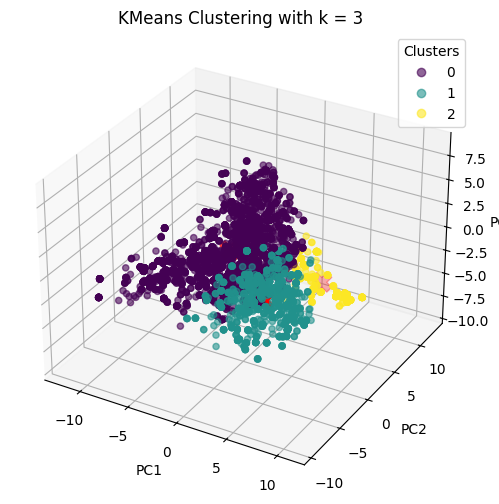

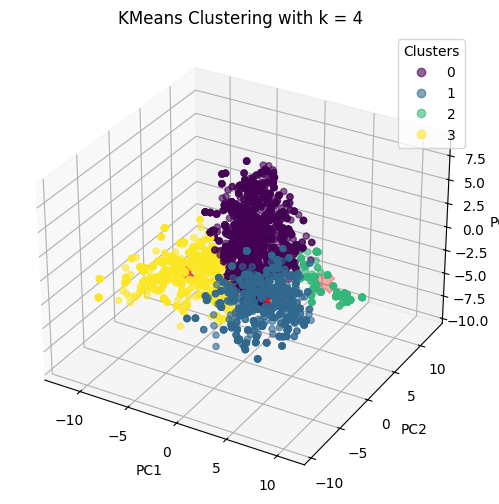

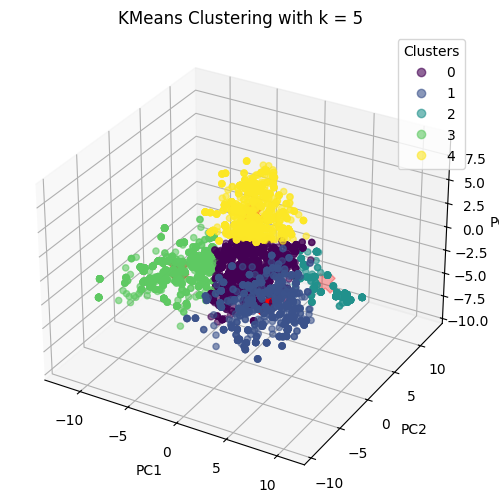

In [ ]:
# Use the PCA-reduced data for clustering
X = df_pca.values

# --- KMeans Clustering ---
print("\n--- KMeans Clustering ---")
# Evaluate silhouette scores for k = 2 to 10
silhouette_scores = {}
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(X)
    score = silhouette_score(X, cluster_labels)
    silhouette_scores[k] = score
    print("Silhouette Score for k = {}: {:.3f}".format(k, score))

# Based on silhouette analysis, choose three values of k (example: 3, 4, and 5)
selected_ks = [3, 4, 5]
for k in selected_ks:
    kmeans = KMeans(n_clusters=k, random_state=42)
    clusters = kmeans.fit_predict(X)
    centroids = kmeans.cluster_centers_

    # Plot 3D clusters with centroids
    fig = plt.figure(figsize=(8,6))
    ax = fig.add_subplot(111, projection='3d')
    scatter = ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=clusters, cmap='viridis', alpha=0.6)
    ax.scatter(centroids[:, 0], centroids[:, 1], centroids[:, 2], marker='X', s=200, c='red')
    ax.set_title(f'KMeans Clustering with k = {k}')
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.set_zlabel('PC3')
    plt.legend(*scatter.legend_elements(), title="Clusters")
    plt.show()




--- Hierarchical Clustering ---


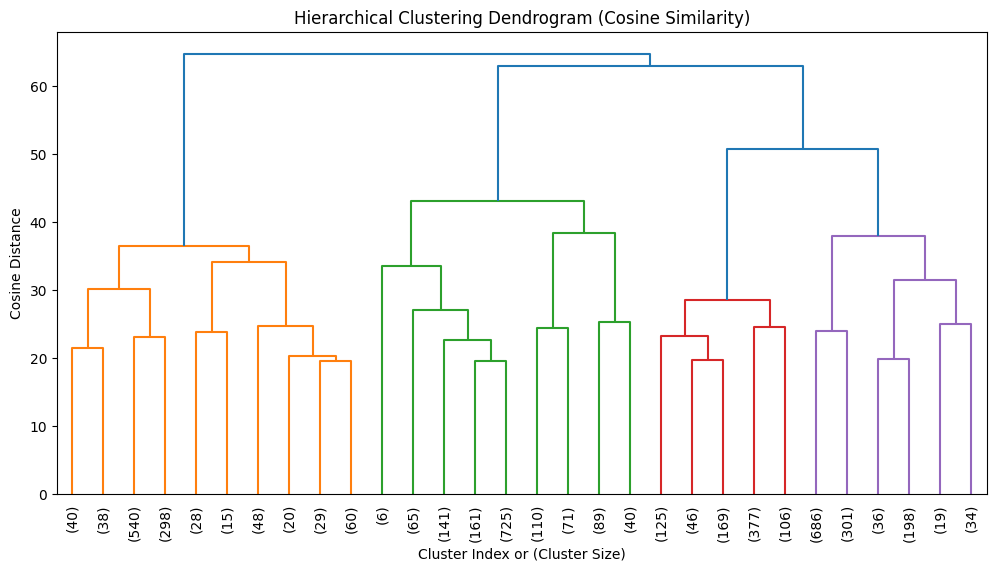

In [ ]:
# --- Hierarchical Clustering ---
print("\n--- Hierarchical Clustering ---")
# Compute the cosine distance matrix for the PCA-reduced data (or your scaled data)
cosine_dist_matrix = cosine_distances(X)

# Perform hierarchical clustering using the cosine distance matrix.
# Here, we use 'average' linkage, but you can try 'complete' or others.
Z_cosine = linkage(cosine_dist_matrix, method='average')

plt.figure(figsize=(12, 6))
dendro = dendrogram(Z_cosine, truncate_mode='lastp', p=30, leaf_rotation=90, leaf_font_size=10)
plt.title("Hierarchical Clustering Dendrogram (Cosine Similarity)")
plt.xlabel("Cluster Index or (Cluster Size)")
plt.ylabel("Cosine Distance")
plt.show()




--- DBSCAN Clustering ---
DBSCAN produced the following cluster labels: [ -1   0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16
  17  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34
  35  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52
  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70
  71  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88
  89  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106
 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124
 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142
 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160
 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178
 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196
 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214
 215 216 217 218 219 220 221 222 223 224 225 226 22

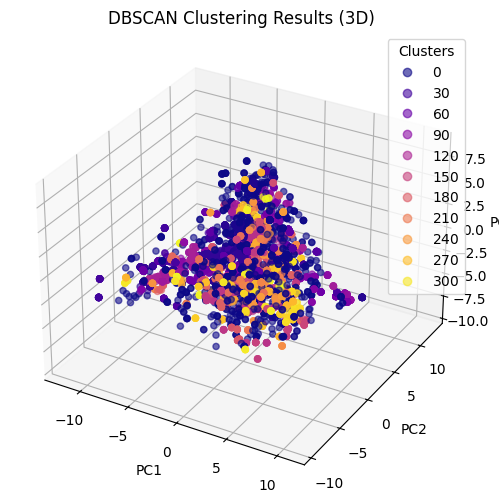

In [ ]:
# --- DBSCAN Clustering ---
print("\n--- DBSCAN Clustering ---")
# Choose eps and min_samples (example values; tuning may be required)
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan_labels = dbscan.fit_predict(X)
unique_dbscan = np.unique(dbscan_labels)
print("DBSCAN produced the following cluster labels:", unique_dbscan)

# Plot DBSCAN results in 3D
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=dbscan_labels, cmap='plasma', alpha=0.6)
ax.set_title("DBSCAN Clustering Results (3D)")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
plt.legend(*scatter.legend_elements(), title="Clusters")
plt.show()



In [ ]:
#Save the clustering results for further analysis.
df_clusters = pd.DataFrame(X, columns=["PC1", "PC2", "PC3"])
df_clusters['KMeans_3'] = KMeans(n_clusters=3, random_state=42).fit_predict(X)
df_clusters['KMeans_4'] = KMeans(n_clusters=4, random_state=42).fit_predict(X)
df_clusters['KMeans_5'] = KMeans(n_clusters=5, random_state=42).fit_predict(X)
df_clusters['DBSCAN'] = dbscan_labels
df_clusters.to_csv("accidents_cluster_results.csv", index=False)
print("\nClustering results saved as: accidents_cluster_results.csv")


Clustering results saved as: accidents_cluster_results.csv


#Association Rule Mining (ARM)

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules
import nltk, string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

# Ensure NLTK data is downloaded
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
punct_table = str.maketrans('', '', string.punctuation)
stemmer = PorterStemmer()

# Load the accident dataset (assumed to be cleaned and labeled)
df = pd.read_csv("accidents_cleaned.csv")
print("Accidents Data Sample (first 5 rows):")
print(df.head())





[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Accidents Data Sample (first 5 rows):
           label           sourc  \
0  road accident         UK news   
1  road accident         UK news   
2  road accident        Football   
3  road accident  Australia news   
4  road accident         US news   

                                                titl  \
0  leicester city helicopter crash ruled an accid...   
1  heavy snowfall across the uk as schools closed...   
2  west ham s michail antonio in stable condition...   
3  two teenagers die after sunshine coast waterfa...   
4  huge response to fundraiser for former congres...   

                                            descript  \
0  the deaths of five people including the former...   
1  we re closing this live blog now thanks for re...   
2  west ham united have asked for privacy for mic...   
3  two 17 year olds have died in the sunshine coa...   
4  a fundraiser for a republican former congressm...   

                                             content  sentiment       a

In [18]:
# Use the 'titl' column to create transactions (unlabeled data for ARM)
def tokenize_and_stem(text):
    if not isinstance(text, str):
        return []
    text = text.lower().translate(punct_table)
    tokens = text.split()
    # Remove stopwords and apply stemming
    tokens = [stemmer.stem(token) for token in tokens if token not in stop_words]
    return tokens

# Create a list of transactions from the 'titl' column
transactions = df['titl'].dropna().apply(tokenize_and_stem).tolist()

# Display sample transactions
print("\nSample Transaction Data (first 5 transactions):")
for i, trans in enumerate(transactions[:5]):
    print(f"Transaction {i+1}: {trans}")




Sample Transaction Data (first 5 transactions):
Transaction 1: ['leicest', 'citi', 'helicopt', 'crash', 'rule', 'accid', 'juri', 'inquest']
Transaction 2: ['heavi', 'snowfal', 'across', 'uk', 'school', 'close', 'train', 'delay', 'road', 'accid', 'report', 'happen']
Transaction 3: ['west', 'ham', 'michail', 'antonio', 'stabl', 'condit', 'seriou', 'car', 'crash']
Transaction 4: ['two', 'teenag', 'die', 'sunshin', 'coast', 'waterfal', 'accid', 'fail', 'rescu', 'attempt']
Transaction 5: ['huge', 'respons', 'fundrais', 'former', 'congressman', 'paralyz', 'accid']


In [20]:
# Save sample transactions for reference
df_trans = pd.DataFrame({'Transaction': [';'.join(t) for t in transactions]})
df_trans.to_csv("transactions_sample.csv", index=False)


In [21]:
# One-hot encode the transaction data
te = TransactionEncoder()
te_array = te.fit(transactions).transform(transactions)
df_onehot = pd.DataFrame(te_array, columns=te.columns_)
print("\nOne-Hot Encoded Transaction Data (first 5 rows):")
print(df_onehot.head())




One-Hot Encoded Transaction Data (first 5 rows):
       0    000  000lb      1     10    100   1000   100f  100mph    101  ...  \
0  False  False  False  False  False  False  False  False   False  False  ...   
1  False  False  False  False  False  False  False  False   False  False  ...   
2  False  False  False  False  False  False  False  False   False  False  ...   
3  False  False  False  False  False  False  False  False   False  False  ...   
4  False  False  False  False  False  False  False  False   False  False  ...   

   youngest  youtub  zakyntho  zandschulp  zealand  zelenskiy  zelenskyy  \
0     False   False     False       False    False      False      False   
1     False   False     False       False    False      False      False   
2     False   False     False       False    False      False      False   
3     False   False     False       False    False      False      False   
4     False   False     False       False    False      False      False   

    zo

In [22]:
# Apply the Apriori algorithm to extract frequent itemsets using a minimum support threshold of 0.01
frequent_itemsets = apriori(df_onehot, min_support=0.01, use_colnames=True)
print("\nFrequent Itemsets (first 5 rows):")
print(frequent_itemsets.head())




Frequent Itemsets (first 5 rows):
    support     itemsets
0  0.236529      (accid)
1  0.010820      (accus)
2  0.010387  (afternoon)
3  0.010820        (age)
4  0.020775        (air)


In [23]:
# Generate association rules with a minimum confidence of 0.3
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.3)
print("\nSample Association Rules:")
print(rules.head())




Sample Association Rules:
    antecedents consequents  antecedent support  consequent support   support  \
0  (australian)     (accid)            0.014932            0.236529  0.010820   
1        (bike)     (accid)            0.014932            0.236529  0.012119   
2        (dead)     (accid)            0.031378            0.236529  0.011253   
3       (death)     (accid)            0.024886            0.236529  0.013417   
4         (die)     (accid)            0.064272            0.236529  0.026185   

   confidence      lift  representativity  leverage  conviction  \
0    0.724638  3.063633               1.0  0.007288    2.772606   
1    0.811594  3.431269               1.0  0.008587    4.052270   
2    0.358621  1.516181               1.0  0.003831    1.190358   
3    0.539130  2.279343               1.0  0.007531    1.656588   
4    0.407407  1.722442               1.0  0.010983    1.288357   

   zhangs_metric   jaccard  certainty  kulczynski  
0       0.683801  0.044964   0.

In [24]:
# Extract and print the top 15 rules by support, confidence, and lift
top15_support = rules.sort_values('support', ascending=False).head(15)
top15_confidence = rules.sort_values('confidence', ascending=False).head(15)
top15_lift = rules.sort_values('lift', ascending=False).head(15)

print("\nTop 15 Rules by Support:")
print(top15_support[['antecedents', 'consequents', 'support', 'confidence', 'lift']])



Top 15 Rules by Support:
       antecedents     consequents   support  confidence       lift
32         (plane)         (crash)  0.054966    0.878893   4.467946
46            (la)          (fire)  0.049124    0.685801   1.533923
22    (california)          (fire)  0.036789    0.726496   1.624945
23           (car)         (crash)  0.032461    0.632911   3.217474
30          (kill)         (crash)  0.031378    0.525362   2.670736
34         (south)         (crash)  0.030513    0.805714   4.095936
58         (trump)          (fire)  0.028565    0.687500   1.537724
60            (us)          (fire)  0.028349    0.472924   1.057784
49           (new)          (fire)  0.026834    0.616915   1.379848
4            (die)         (accid)  0.026185    0.407407   1.722442
45          (hous)          (fire)  0.025103    0.892308   1.995815
72         (korea)         (south)  0.024021    1.000000  26.405714
89         (korea)  (south, crash)  0.024021    1.000000  32.773050
71         (south)    

In [25]:
print("\nTop 15 Rules by Confidence:")
print(top15_confidence[['antecedents', 'consequents', 'support', 'confidence', 'lift']])



Top 15 Rules by Confidence:
         antecedents      consequents   support  confidence       lift
31           (korea)          (crash)  0.024021         1.0   5.083608
16           (angel)             (lo)  0.014066         1.0  71.092308
69          (renner)         (jeremi)  0.010604         1.0  85.574074
72           (korea)          (south)  0.024021         1.0  26.405714
77   (accid, jeremi)         (renner)  0.010604         1.0  94.306122
78   (accid, renner)         (jeremi)  0.010604         1.0  85.574074
79  (renner, jeremi)          (accid)  0.010604         1.0   4.227813
81          (renner)  (accid, jeremi)  0.010604         1.0  94.306122
82    (plane, korea)          (crash)  0.016447         1.0   5.083608
86    (south, korea)          (crash)  0.024021         1.0   5.083608
87    (crash, korea)          (south)  0.024021         1.0  26.405714
89           (korea)   (south, crash)  0.024021         1.0  32.773050
90    (south, plane)          (crash)  0.021424 

In [26]:
print("\nTop 15 Rules by Lift:")
print(top15_lift[['antecedents', 'consequents', 'support', 'confidence', 'lift']])


Top 15 Rules by Lift:
         antecedents      consequents   support  confidence       lift
14           (updat)      (afternoon)  0.010387    1.000000  96.270833
13       (afternoon)          (updat)  0.010387    1.000000  96.270833
81          (renner)  (accid, jeremi)  0.010604    1.000000  94.306122
77   (accid, jeremi)         (renner)  0.010604    1.000000  94.306122
68          (jeremi)         (renner)  0.010604    0.907407  85.574074
80          (jeremi)  (accid, renner)  0.010604    0.907407  85.574074
69          (renner)         (jeremi)  0.010604    1.000000  85.574074
78   (accid, renner)         (jeremi)  0.010604    1.000000  85.574074
17              (lo)          (angel)  0.014066    1.000000  71.092308
16           (angel)             (lo)  0.014066    1.000000  71.092308
66             (ham)           (west)  0.010171    1.000000  53.114943
67            (west)            (ham)  0.010171    0.540230  53.114943
85    (south, crash)          (korea)  0.024021    0.7

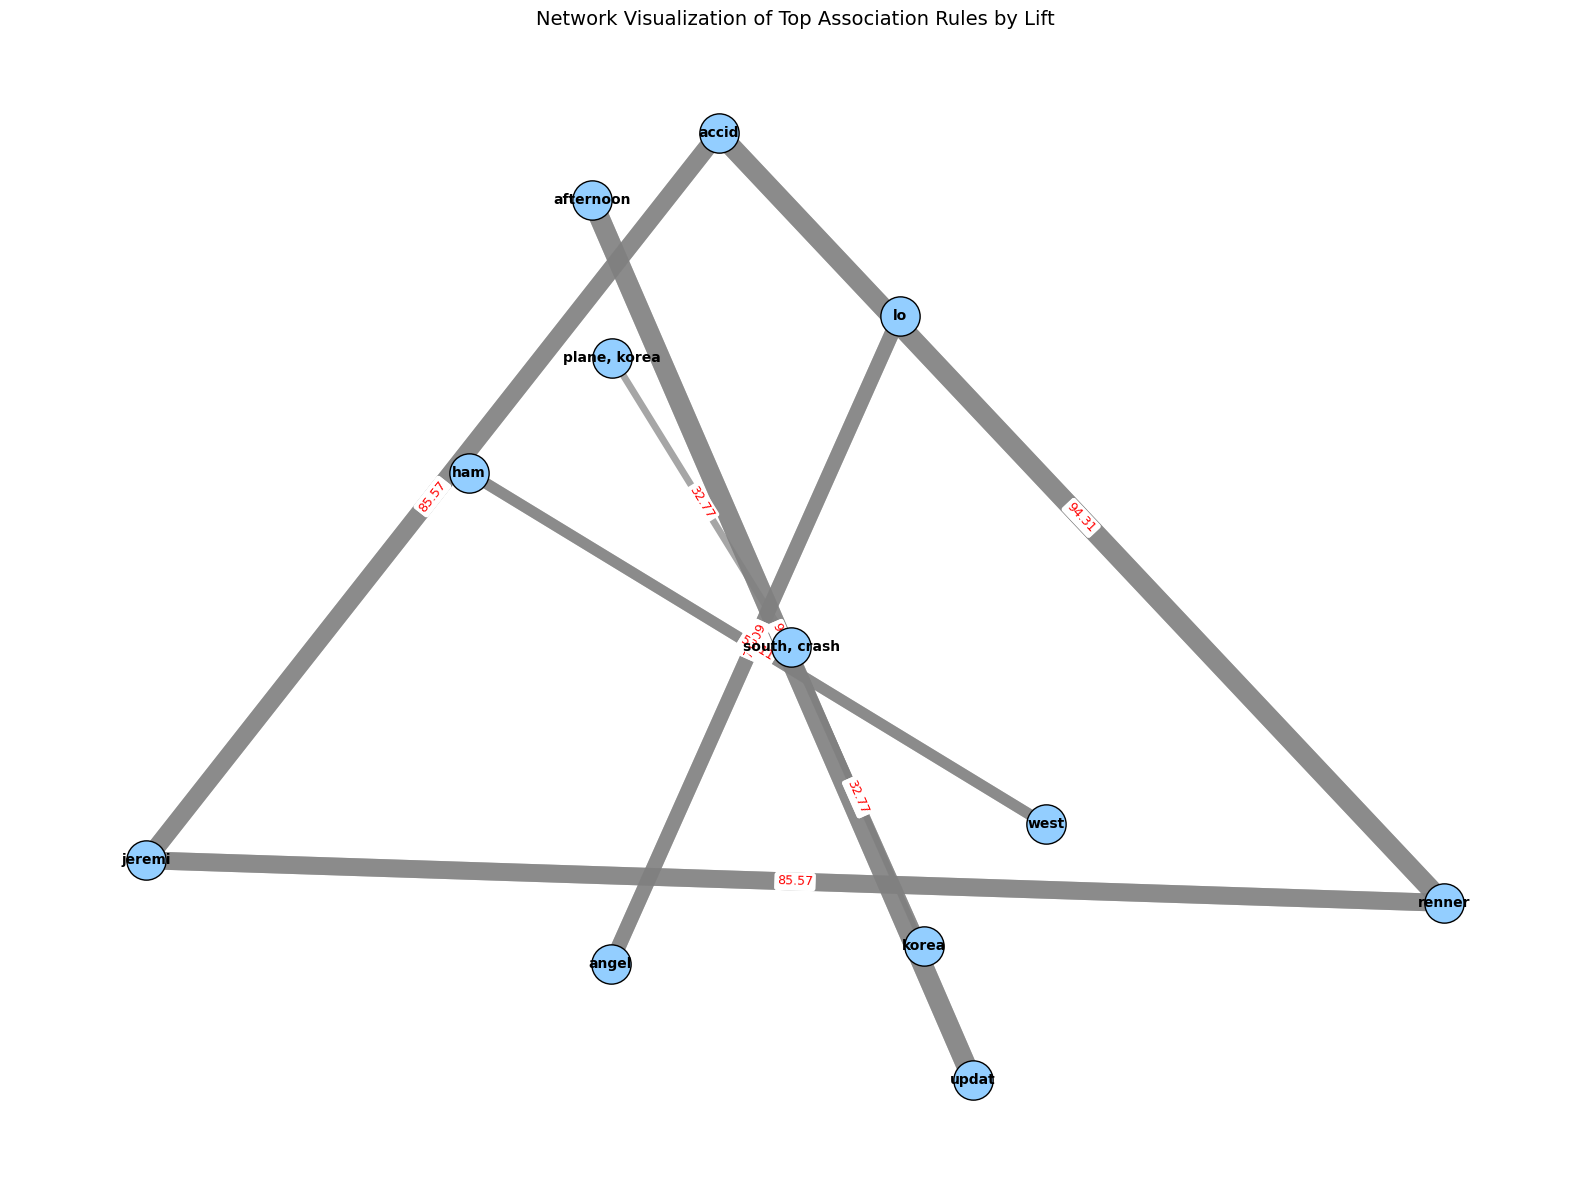

In [16]:
# Create a network visualization of the top 15 rules (by lift)
import matplotlib.pyplot as plt
import networkx as nx
G = nx.DiGraph()

for _, row in top15_lift.iterrows():
    antecedents = list(row['antecedents'])
    consequents = list(row['consequents'])

    # Add each antecedent and consequent as nodes
    for ant in antecedents:
        G.add_node(ant)
    for con in consequents:
        G.add_node(con)

    # Add edges between antecedents and consequents
    # Store the lift value as 'weight'
    for ant in antecedents:
        for con in consequents:
            G.add_edge(ant, con, weight=row['lift'])

plt.figure(figsize=(16, 12))
# Use Kamada-Kawai layout for balanced node spacing
pos = nx.kamada_kawai_layout(G)
# Scale edge widths by lift to highlight stronger associations
edge_widths = [G[u][v]['weight'] * 0.15 for u, v in G.edges()]
# Draw nodes (light blue, black outline, moderate size)
nx.draw_networkx_nodes(
    G,
    pos,
    node_size=800,
    node_color="#93ceff",
    edgecolors="black",
    linewidths=1
)

# Draw edges (gray lines, scaled widths, slight transparency)
nx.draw_networkx_edges(
    G,
    pos,
    width=edge_widths,
    edge_color="gray",
    alpha=0.7,
    arrows=False  # Set to True if you prefer arrowheads for a DiGraph
)

# Draw node labels in bold
nx.draw_networkx_labels(
    G,
    pos,
    font_size=10,
    font_family="sans-serif",
    font_weight="bold"

)

# Create edge labels from the 'weight' (lift) values, rounded to 2 decimals
edge_labels = {
    (u, v): f"{G[u][v]['weight']:.2f}"
    for u, v in G.edges()
}

# Draw edge labels inside small white boxes to reduce clutter
nx.draw_networkx_edge_labels(
    G,
    pos,
    edge_labels=edge_labels,
    font_color="red",
    font_size=9,
    label_pos=0.5,  # Position label at midpoint of edge
    bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="none")
)

# Finalize plot
plt.title("Network Visualization of Top Association Rules by Lift", fontsize=14)
plt.axis("off")  # Hide axis lines
plt.tight_layout()  # Adjust layout to minimize overlaps
plt.show()
